# Master Data Analytics - CA2 Integrated

.

<b>Please install the following libraries to run this project:</b>

In [1]:
#pip install ipython-sql
#pip install mysqlclient
#pip install mysql-connector-python
#pip install pymysql
#pip install vaderSentiment
#pip install -U textblob
#pip install skforecast --user
#pip install scalecast
#pip install ipympl
#pip install mpl_interactions
#pip install ipywidgets

<b>Libraries</b>

In [2]:
import numpy as np              
import pandas as pd             
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns  # library for making statistical graphics in Python.
from datetime import timedelta

import mysql.connector
import pymysql

from pyspark.sql import SparkSession

# Load vaderSentimental library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from joblib import dump, load

import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Create and initialise an object
sentiment = SentimentIntensityAnalyzer()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>Mysql Connection:</b>

Please intall the my sql connector version 8.1.0

PLEASE, RUN THE COMMANDS BELOW ON TERMINAL TO CREATE AND GRANT PERMISSIONS TO user1:
<br/>
<br/>
mysql -u root -p
<br/>
CREATE USER 'user1'@'%%' IDENTIFIED BY 'Pass@word1';
<br/>
GRANT ALL PRIVILEGES ON * . * TO 'Pass@word1'@'%%';
<br/>
FLUSH PRIVILEGES;
<br/>

In [3]:
# Creating a connection to the mySQL database 
connMySQL = pymysql.connect(host = 'localhost',
                             user = 'user1',
                             password = 'Pass@word1',
                             db = 'dbTwitter')

cursor = connMySQL.cursor()

<b>Global Variables:</b>

In [4]:
# Path to data set
csv_file = "file:///home/hduser/Downloads/work2/ProjectTweets.csv"

# Data Understanding - Part 1

<b>Creating a new spark session and load CSV data to a temporary spark table and to a spark dataframe: </b>

In [5]:
# Create a SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Read and create a temporary view
# The dataset doesnt contain header, so header = false
# toDF to define appropriated column name
dfTwitter = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "false")
  .load(csv_file)
  .toDF('id', 'seq', 'date', 'query', 'user', 'tweet'))

dfTwitter.createOrReplaceTempView("tblTempTwitter")


<b>Printing some records to take a first look on the dataset:</b>

In [6]:
spark.sql("""SELECT * FROM tblTempTwitter""").show(10)

+---+----------+--------------------+--------+---------------+--------------------+
| id|       seq|                date|   query|           user|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [7]:
spark.sql("""SELECT tweet FROM tblTempTwitter""").show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|my whole body feels itchy and like its on fire                                                                     |
|@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |
|@Kwesidei not the whole crew                           

In [8]:
spark.sql("""SELECT date FROM tblTempTwitter""").show(10, truncate=False)

+----------------------------+
|date                        |
+----------------------------+
|Mon Apr 06 22:19:45 PDT 2009|
|Mon Apr 06 22:19:49 PDT 2009|
|Mon Apr 06 22:19:53 PDT 2009|
|Mon Apr 06 22:19:57 PDT 2009|
|Mon Apr 06 22:19:57 PDT 2009|
|Mon Apr 06 22:20:00 PDT 2009|
|Mon Apr 06 22:20:03 PDT 2009|
|Mon Apr 06 22:20:03 PDT 2009|
|Mon Apr 06 22:20:05 PDT 2009|
|Mon Apr 06 22:20:09 PDT 2009|
+----------------------------+
only showing top 10 rows



In [9]:
spark.sql("""S;""").show(10)

ParseException: 
mismatched input 'S' expecting {'(', 'ADD', 'ALTER', 'ANALYZE', 'CACHE', 'CLEAR', 'COMMENT', 'COMMIT', 'CREATE', 'DELETE', 'DESC', 'DESCRIBE', 'DFS', 'DROP', 'EXPLAIN', 'EXPORT', 'FROM', 'GRANT', 'IMPORT', 'INSERT', 'LIST', 'LOAD', 'LOCK', 'MAP', 'MERGE', 'MSCK', 'REDUCE', 'REFRESH', 'REPLACE', 'RESET', 'REVOKE', 'ROLLBACK', 'SELECT', 'SET', 'SHOW', 'START', 'TABLE', 'TRUNCATE', 'UNCACHE', 'UNLOCK', 'UPDATE', 'USE', 'VALUES', 'WITH'}(line 1, pos 0)

== SQL ==
S;
^^^


In [ ]:
spark.sql("""SELECT seq, COUNT(seq) as total FROM tblTempTwitter GROUP BY seq ORDER BY seq desc;""").show(10)

In [ ]:
spark.sql("""SELECT query FROM tblTempTwitter where query != 'NO_QUERY'""").show(10)

In [ ]:
spark.sql("""SELECT tweet FROM tblTempTwitter where tweet = '' OR tweet is NULL""").show(10)

In [ ]:
spark.sql("""SELECT user, COUNT(user) as total FROM tblTempTwitter GROUP BY user ORDER BY total desc;""").show(20)



Looking for null or blank date values

In [ ]:
spark.sql("""SELECT user, tweet FROM tblTempTwitter where date is null or date =='';""").show(20)


# Data Preparation

## SPARK HIVE

Creating a Database, table and proccessing data in Hive Metastore. 
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table name:</b> tblTwitter
<br/>
<b>Operation:</b> Store the CSV file in a permanent table in HIVE (Spark). This hive table will be used as a performance comparation with MySQL
<br/>


In [10]:
#Creating a Database dbTwitter in Hive
spark.sql("CREATE DATABASE IF NOT EXISTS dbTwitter")



2023-10-30 13:00:58,398 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-30 13:00:58,400 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-30 13:01:02,844 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-10-30 13:01:02,845 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-10-30 13:01:03,341 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-10-30 13:01:03,362 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Database dbtwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_database(HiveMetaStore.java:925)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeM

DataFrame[]

Using spark.sql() method "CREATE TABLE" to create a table in Hive from the spark temporary view tblTempTwitter.

In [11]:
#Create a Table in Hive tblTwitter on the bdTwitter database.
spark.sql("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id Int, seq Double, date String, query String, user String, tweet String)")



2023-10-30 13:01:03,550 WARN analysis.ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
2023-10-30 13:01:04,288 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-10-30 13:01:04,579 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-10-30 13:01:04,579 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-30 13:01:04,580 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-30 13:01:04,638 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Table tbltwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_core(HiveMetaStore.java:1416)
	at org.apach

DataFrame[]

Inserting data from the spark temporary view tblTempTwitter into the Hive table tblTwitter:

In [12]:
#query to test if the table has rows, if has is because the code is been processed again and we do not need to reproccess
query = spark.sql("Select * from dbTwitter.tblTwitter LIMIT 1;")

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data
    #Insert into Hive tblTwitter using the spar temp view tblTempTwitter. 
    spark.sql("INSERT INTO TABLE dbTwitter.tblTwitter SELECT * FROM tblTempTwitter")    
else:
    print("Table is not empty!")


Table is not empty!


In [13]:
#Lets view the data in the hive table
spark.sql("SELECT * FROM dbTwitter.tblTwitter").show(10)

+------+-------------+--------------------+--------+---------------+--------------------+
|    id|          seq|                date|   query|           user|               tweet|
+------+-------------+--------------------+--------+---------------+--------------------+
|545133|2.201337104E9|Tue Jun 16 20:08:...|NO_QUERY|      alt_ducky|@miss_clariss oh ...|
|545134|2.201337108E9|Tue Jun 16 20:08:...|NO_QUERY|     CourtneyVR|Failed my WOF. Wi...|
|545135|2.201337287E9|Tue Jun 16 20:08:...|NO_QUERY|    melissaholt|Watching the firs...|
|545136|2.201337425E9|Tue Jun 16 20:08:...|NO_QUERY|       itznesha|my computer is in...|
|545137|2.201337512E9|Tue Jun 16 20:08:...|NO_QUERY|    lovinmyboys|Worked out my upp...|
|545138|2.201337757E9|Tue Jun 16 20:08:...|NO_QUERY|     mikerbrant|OMG I got my new ...|
|545139|2.201338077E9|Tue Jun 16 20:08:...|NO_QUERY|         daulex|my back has flare...|
|545140|2.201338113E9|Tue Jun 16 20:08:...|NO_QUERY|    CaliHeather|I am starting to ...|
|545141|2.

## MySQL

Creating a Database, tables and proccess data with MySQL
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table names:</b> tblTwitter, tblTwitterPrep
<br/>
<b>Details:</b> 
<br/>
MySQL is used to do the Data Preparation in this project.
<br/>
New tables were created, new features, data transformation, and all necessary steps to prepare the data to be fit on the forecast model.

<b>Creating a new database and the first table on MySQL:</b>

In [14]:

#Creating a new database if not exists
cursor.execute("CREATE DATABASE IF NOT EXISTS dbTwitter;")
#Use the dbTwitter in the context
cursor.execute("USE dbTwitter;")

#Creating a new table if not exists
cursor.execute("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id NUMERIC, seq NUMERIC, date VARCHAR(50), query VARCHAR(50), user VARCHAR(50), tweet TEXT)")

0

<b>Copy the data from Hive table to the correspondent table in MySQL: </b>

In [15]:
#COPY the data from HIVE table to My SQL table

query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitter LIMIT 1;')

#Test if the table is empty
if not query:
    # convert the spark dataframe to pandas dataframe to iterate 
    dfPandasTwitter = dfTwitter.toPandas()
    
    #If the table is empty, them execute the code to fill with the dataset data
    # reading the columns to use on the insert clause
    cols = ",".join([str(i) for i in dfPandasTwitter.columns.tolist()])

    # Insert on the mySQL table all records from SPark SQL
    for i, row in dfPandasTwitter.iterrows():
        sql = "INSERT INTO tblTwitter (" + cols + ") VALUES (" + "%s," * (len(row) - 1) + "%s)"
        cursor.execute(sql, tuple(row))
        
        # the connection is not autocommitted by default, so commit command is necessary to save the changes
        connMySQL.commit()
else:
    print ("This table is not empty!")



This table is not empty!


<b>Creating a new table with the new necessary features:</b>
<br/>
<br/>
The idea is keeping the original table to be used in the performance comparision, all the data preparation will be processed in this new table.
<br/>
<br/>
<b>New features:</b>
<li>date_custom: Date</li>
<li>week: Char(3)</li>
<li>hour: Int</li>
<li>minute: Int</li>
<li>second: Int</li>
<li>day: Int</li>
<li>month: Int</li>
<li>year: Int</li>
<li>sentiment: Double</li>

In [17]:
# Creating the new table to start the data preparation
# It was excluded 
cursor.execute("""CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitterPreparation (
                id Int, 
                date VARCHAR(50), 
                user VARCHAR(50),                 
                tweet TEXT, 
                tweet_review TEXT, 
                date_custom Date,
                week CHAR(3), 
                hour Int, 
                minute Int, 
                second Int, 
                day Int, 
                month Int, 
                year Int, 
                sentiment_vader Double,
                sentiment_blob Double,
                INDEX (id))
              """)

connMySQL.commit()

In [18]:

#cursor.execute("DROP TABLE dbTwitter.tblTwitterPreparation;")
#connMySQL.commit()

<b>Inserting data to the Data Preparation table (tblTwitterPrep) transforming data during the proccess:</b>
<br/>
<br/>
Substring function is used to split the original date value to separeted columns like day, year, hour... These columns can be usefull to plot graphs or to fit in the Machine Learning models.
<br/>
Switch case is used to transform the text value of month (apr, may, jun) into a number value (4, 5 ,6).
<br/>
a DD/MM/YYYY will be processed after this step.
<br/>
<br/>
<b>Original date format:</b> Mon Apr 06 22:19:45 PDT 2009	
<br/>
.

In [19]:
query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitterPreparation LIMIT 1;')

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data    
    
    cursor.execute("""INSERT INTO dbTwitter.tblTwitterPreparation 
                  (id, date, user, tweet, 
                  tweet_review, date_custom, 
                  week, hour, minute, second, 
                  day, month, year, sentiment_vader, sentiment_blob)
                  SELECT id, 
                  date, 
                  user, 
                  tweet,
                  NULL,
                  NULL,
                  SUBSTR(date, 1, 3), 
                  SUBSTR(date, 12, 2), 
                  SUBSTR(date, 15, 2),                    
                  SUBSTR(date, 18, 2),                                      
                  SUBSTR(date, 9, 2),                                                        
                  CASE SUBSTR(date, 5, 3)                      
                      WHEN 'apr' THEN 4
                      WHEN 'may' THEN 5
                      WHEN 'jun' THEN 6                      
                      ELSE NULL
                  END,   
                  SUBSTR(date, 25, 4),                                                                          
                  0.0,  
                  0.0
                  FROM dbTwitter.tblTwitter;""")   
    
    connMySQL.commit()
    
else:
    print("Table is not empty!")



Table is not empty!


<b>Creating a YYYY/MM/DD date value:</b>

In [12]:

sql = """UPDATE dbTwitter.tblTwitterPreparation t1, dbTwitter.tblTwitterPreparation t2 
SET t1.date_custom = STR_TO_DATE( 
         CONCAT( t2.day, '/', t2.month, '/', t2.year ), '%d/%m/%Y')
WHERE t1.id = t2.id"""

cursor.execute(sql)

connMySQL.commit()

 - a positive sentiment, compound ≥ 0.05.
 - a negative sentiment, compound ≤ -0.05.
 - a neutral sentiment, the compound is between ]-0.05, 0.05[


#### Calculating the sentiment (Vader and Blob)

Each tweet will have the text sentiment calculated using Vader and Blob.
<br/>
This is an step to prepare the data for forecasting.
<br/>
<br/>
<b><span style="color:red">I strongly do not recommend </span>to run the vader and blob calculation step below. Even using index to tunning the table, this step took more than one hour to be processed. Instead you can restore the database backup submitted.



In [21]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [22]:
#Loading all the rows to be proccessed with the sentiment
dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)


In [6]:
#Loading all the rows to be proccessed with the sentiment
#dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)

#Iterate on the dataset to calculate the sentiment of each tweet and store on the database
for i, row in dfTweets.iterrows():
    
    #processing tweet to remove stop words to best fit on the sentiment analysis
    tweet_reviewed = get_text_processing(row["tweet"])    
        
    #Calculate the sentiment using Vader 
    sent_vader = sentiment.polarity_scores(tweet_reviewed)['compound']
    #Calculate the sentiment using Text Blob
    sent_blob = TextBlob(tweet_reviewed).sentiment[0]
    
    sql = "UPDATE dbTwitter.tblTwitterPreparation SET "
    sql += "sentiment_vader = " + str(sent_vader) + ", "
    sql += "sentiment_blob = " + str(sent_blob) + ", "
    sql += "tweet_review = '" + str(tweet_reviewed) + "' "
    sql += " WHERE id = " + str(row["id"]) + ";"
    
    cursor.execute(sql)    
    
    # the connection is not autocommitted by default, so commit command is necessary to save the changes
    connMySQL.commit()    
    

# Data Understanding - Part 2

Having the original date value splitted in different columns will allow to performing better analysis on the data quality.
<br/>
Group by clauses are now possible (or at least easier) to be performed and some analysis can be prepared, like:
<li>Searching for missing tweets per day</li>
<li>Searching for missing tweets per hour</li>
<li>Analysing the weight difference between days/months</li>

In [23]:
# Command to autoformat date axis
plt.gcf().autofmt_xdate();

<Figure size 640x480 with 0 Axes>

### Average sentiment per day

Analyzing tweets sentiment per day and compare between vader and blob:

In [24]:
sql1 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict1 = pd.read_sql(sql = sql1, con = connMySQL)


In [25]:
dfTweetsPredict1.shape

(48, 3)

In [26]:
dfTweetsPredict1

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.155006,0.094019
1,2009-04-07,0.170903,0.099391
2,2009-04-17,0.208811,0.121702
3,2009-04-18,0.186284,0.112139
4,2009-04-19,0.191934,0.114881
5,2009-04-20,0.183340,0.111665
6,2009-04-21,0.182650,0.109819
7,2009-05-01,0.184256,0.111823
8,2009-05-02,0.186152,0.114778
9,2009-05-03,0.178122,0.108815


<b>Plotting comparative between Vader and Blob (average per day)</b>

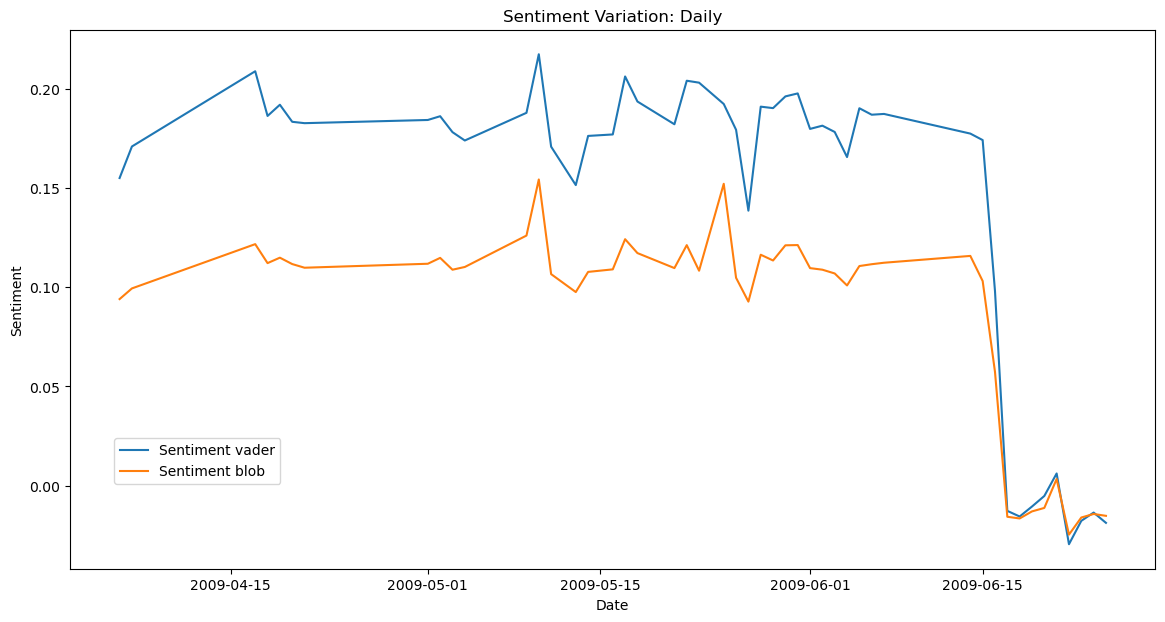

In [27]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict1['date'], dfTweetsPredict1['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(0.2, 0.2)) #Better positioning the legend

### Average Sentiment per hour

Analysing sentiment average per hour:

In [28]:
sql2 = """SELECT DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i') as date, 
        AVG(sentiment_vader) as sentiment_vader,
        AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')
ORDER BY DATE_FORMAT(concat(year, '/', month, '/', day, ' ', hour, ':', '00'), '%Y/%m/%d %H:%i')"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [29]:
dfTweetsPredict2.shape

(593, 3)

In [30]:
pd.set_option('display.max_rows', None)
dfTweetsPredict2

,date,sentiment_vader,sentiment_blob
0,2009/04/06 22:00,0.143017,0.085042
1,2009/04/06 23:00,0.163088,0.100071
2,2009/04/07 00:00,0.175061,0.103789
3,2009/04/07 01:00,0.170414,0.105734
4,2009/04/07 02:00,0.181674,0.102587
5,2009/04/07 03:00,0.168963,0.099639
6,2009/04/07 04:00,0.172308,0.105800
7,2009/04/07 05:00,0.165456,0.091903
8,2009/04/07 06:00,0.171277,0.098949
9,2009/04/07 07:00,0.167515,0.086663


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


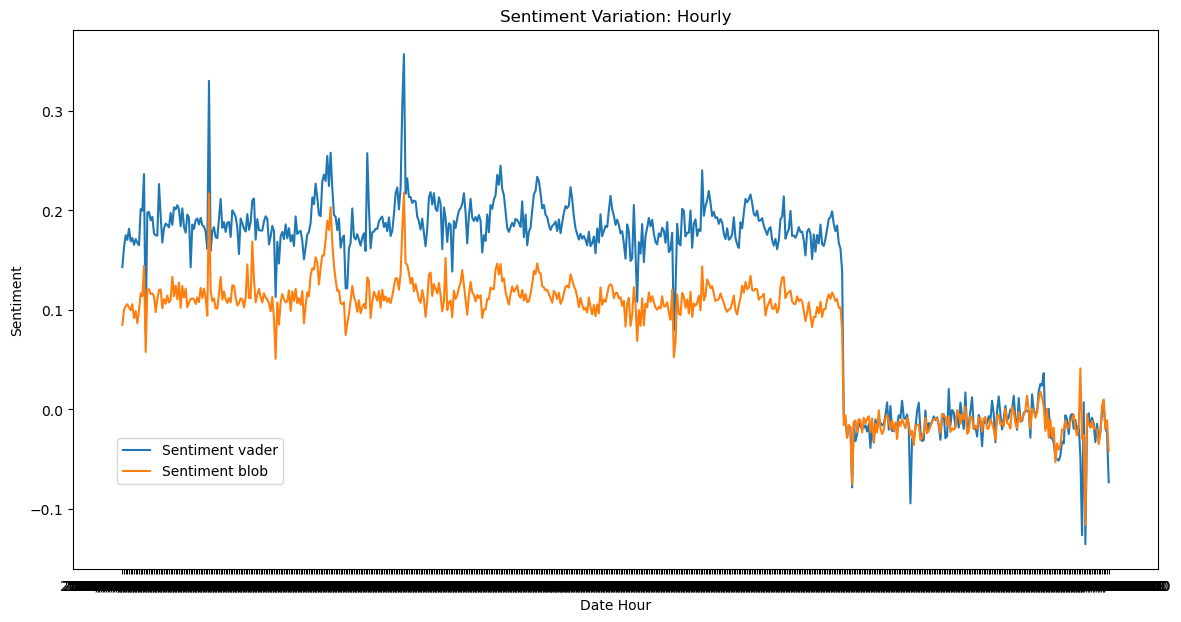

In [31]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Hourly");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(0.2, 0.2)) #Better positioning the legend

### Average Sentiment per day - Only last hour (23:00)

Analysing average sentiment by the last our per day:

In [32]:
sql3 = """SELECT date_custom as date, 
                AVG(sentiment_vader) as sentiment_vader, 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE hour = 23
GROUP BY date_custom
ORDER BY date_custom"""

dfTweetsPredict3 = pd.read_sql(sql = sql3, con = connMySQL)



In [33]:
dfTweetsPredict3.head()

,date,sentiment_vader,sentiment_blob
0,2009-04-06,0.163088,0.100071
1,2009-04-18,0.185251,0.114516
2,2009-04-19,0.181441,0.110693
3,2009-04-20,0.178800,0.108793
4,2009-05-01,0.187770,0.107055


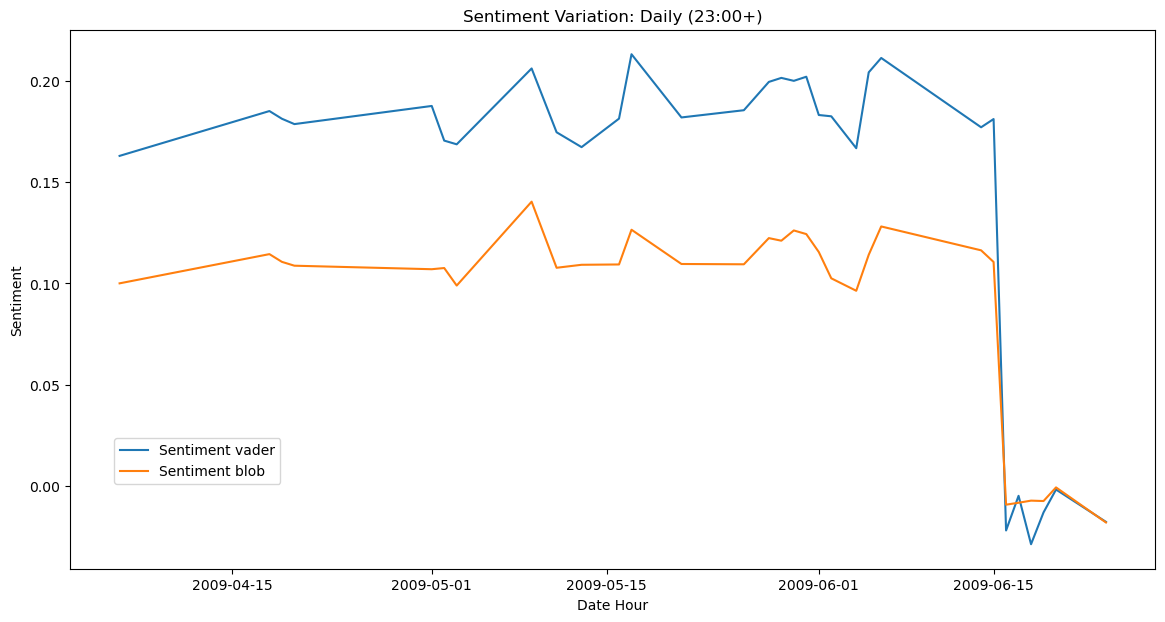

In [34]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_vader'], label='Sentiment vader');  # Plot first line of data.
ax.plot(dfTweetsPredict3['date'], dfTweetsPredict3['sentiment_blob'], label='Sentiment blob');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily (23:00+)");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(0.2, 0.2)) #Better positioning the legend

### Average sentiment per day - Textblob Comparative with/without 0 values

Analyzing average daily sentiment removing results = 0 against complete results:

In [35]:
sql4 = """SELECT CONVERT(date_custom, DATE) as date, 
                AVG(sentiment_blob) as sentiment_blob                
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict4 = pd.read_sql(sql = sql4, con = connMySQL)


sql44 = """SELECT CONVERT(date_custom, DATE) as date,                 
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
GROUP BY CONVERT(date_custom, DATE)
ORDER BY CONVERT(date_custom, DATE)"""

dfTweetsPredict44 = pd.read_sql(sql = sql44, con = connMySQL)

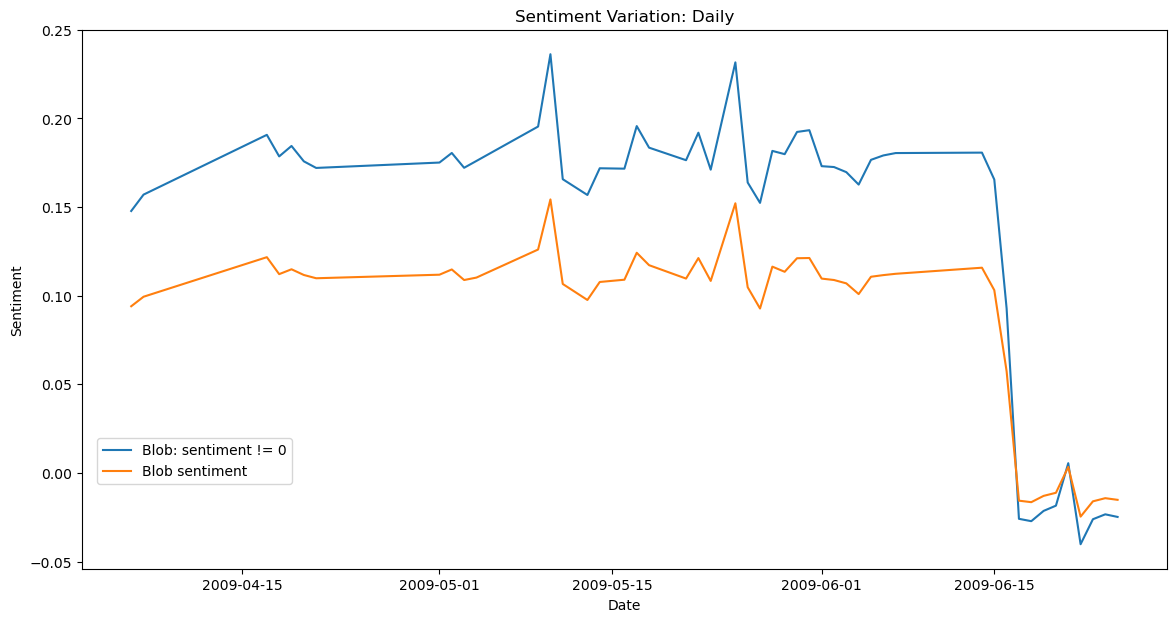

In [36]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPredict4['date'], dfTweetsPredict4['sentiment_blob'], label='Blob: sentiment != 0');  # Plot first line of data.
ax.plot(dfTweetsPredict44['date'], dfTweetsPredict44['sentiment_blob'], label='Blob sentiment');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(0.2, 0.2)) #Better positioning the legend

# Data Preparation - Part 2

Applying the newest insights to the dataset:

In [37]:
# This variable controls if the april data will be prepared to be used on the forecast analysis.
# April is the month with less data
bWithAprilData = True

#Getting average sentiment per day excluding zero values and dates values
sqlPrep = """SELECT CONVERT(date_custom, DATE) as date, 
                week,
                AVG(sentiment_blob) as sentiment_blob
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment_blob != 0
GROUP BY CONVERT(date_custom, DATE), week
ORDER BY CONVERT(date_custom, DATE), week"""


dfTweetsPrep = pd.read_sql(sql = sqlPrep, con = connMySQL)

dfTweetsPrep.head()

,date,week,sentiment_blob
0,2009-04-06,Mon,0.147757
1,2009-04-07,Tue,0.157000
2,2009-04-17,Fri,0.190716
3,2009-04-18,Sat,0.178559
4,2009-04-19,Sun,0.184444


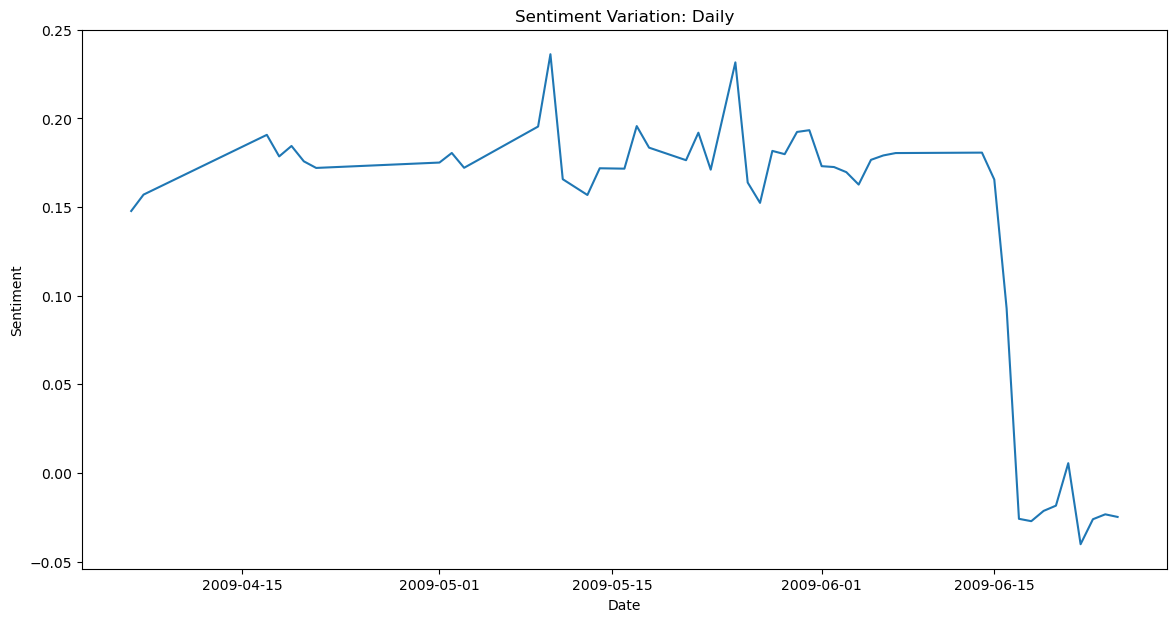

In [38]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPrep['date'], dfTweetsPrep['sentiment_blob'], label='Blob sentiment');  # Plot first line of data.

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [39]:
#Function to include dataset new rows 
def fInserRow(pDate, pWeek, pSent, df):
    new_row = {'date': pDate, 'week': pWeek, 'sentiment_blob': pSent }
    df = df.append(new_row, ignore_index = True)
    return df


<b>Including missing values</b>

All the rules applied to include the missing values is found on the paper work.
<br/>
Basically were:
<br/>
<li> Decrease/Growth pattern using percentage. Ex: If a value had a downward trend, the average percentage of decline was used to calculate the missing value.</li>    
<li> Average day of the week based on the following values. Ex: Average of the following Sundays.</li>
<li> Shift of data to the following week: Ex: April had days missing for more than one week, the previous week was pushed forward reducing the difference from 9 to 2 days.</li>

In [40]:

if bWithAprilData :
    #with april values
    dfTweetsPrep = dfTweetsPrep.drop(index = [36,37,38,39,40,41,42,43,44,45,46,47])
else:
    # without april and june
    dfTweetsPrep = dfTweetsPrep.drop(index = [0,1,2,3,4,5,6,7,8,9,36,37,38,39,40,41,42,43,44,45,46,47])

# 2009-05-19 value
# to calculate 2009-05-19 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
percent = (dfTweetsPrep.iloc[17, 2] * 100 / dfTweetsPrep.iloc[18, 2]) - 100
sent = dfTweetsPrep.iloc[18, 2] - (dfTweetsPrep.iloc[18, 2] * (percent / 100))
dfTweetsPrep = fInserRow('2009-05-19', 'Tue', sent, dfTweetsPrep)

# 2009-05-20 value
# to calculate 2009-05-20 value, lets calculate the decrease percentage of change from the 2 values before and apply the same difference
# same percent before
sent = sent - (sent * (percent / 100))
dfTweetsPrep = fInserRow('2009-05-20', 'Wed', sent, dfTweetsPrep)

# 2009-05-24 value
dfTweetsPrep = fInserRow('2009-05-24', 'Sun', 0.24, dfTweetsPrep)

# 2009-05-15 value
# to calculate 2009-05-15 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[16, 2] + dfTweetsPrep.iloc[14, 2]) / 2
dfTweetsPrep = fInserRow('2009-05-15', 'Fri', sent, dfTweetsPrep)

# 2009-05-12 value
# to calculate 2009-05-12 value, lets calculate the average pair values
sent = (dfTweetsPrep.iloc[11, 2] + dfTweetsPrep.iloc[13, 2]) / 2
dfTweetsPrep = fInserRow('2009-05-12', 'Tue', sent, dfTweetsPrep)

# 2009-05-05 value
dfTweetsPrep = fInserRow('2009-05-05', 'Tue', 0.179233, dfTweetsPrep)

# 2009-05-06 value
dfTweetsPrep = fInserRow('2009-05-06', 'Wed', 0.182467, dfTweetsPrep)

# 2009-05-07 value
dfTweetsPrep = fInserRow('2009-05-07', 'Thu', 0.190012, dfTweetsPrep)

# 2009-05-08 value
dfTweetsPrep = fInserRow('2009-05-08', 'Fri', 0.194323, dfTweetsPrep)


if bWithAprilData :

    dfTweetsPrep.loc[0, ['date']] = dfTweetsPrep.loc[0, ['date']] + timedelta(days = 14)
    dfTweetsPrep.loc[1, ['date']] = dfTweetsPrep.loc[1, ['date']] + timedelta(days = 14)
    dfTweetsPrep.loc[2, ['date']] = dfTweetsPrep.loc[2, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[3, ['date']] = dfTweetsPrep.loc[3, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[4, ['date']] = dfTweetsPrep.loc[4, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[5, ['date']] = dfTweetsPrep.loc[5, ['date']] + timedelta(days = 7)
    dfTweetsPrep.loc[6, ['date']] = dfTweetsPrep.loc[6, ['date']] + timedelta(days = 7)
    
    # 2009-04-22 value
    dfTweetsPrep = fInserRow('2009-04-22', 'Wed', 0.14, dfTweetsPrep)    

    # 2009-04-23 value
    dfTweetsPrep = fInserRow('2009-04-23', 'Thu', 0.16, dfTweetsPrep)    

    # 2009-04-29 value
    dfTweetsPrep = fInserRow('2009-04-29', 'Wed', 0.16, dfTweetsPrep)    

    # 2009-04-30 value
    dfTweetsPrep = fInserRow('2009-04-30', 'Thu', 0.17, dfTweetsPrep)


#dfTweetsPrep['date'] = dfTweetsPrep['date'].astype('datetime64[ns]')
#dfTweetsPrep['sentiment_blob'] = dfTweetsPrep['sentiment_blob'].astype('float')

#dfTweetsPrep.sort_values(by = 'date', inplace = True)

dfTweetsPrep.drop('week', axis = 1, inplace = True)

dfTweetsPrep['sentiment_blob'] = dfTweetsPrep['sentiment_blob'].astype('float')
dfTweetsPrep['date'] = pd.to_datetime(dfTweetsPrep['date'], format='%Y/%m/%d')
dfTweetsPrep = dfTweetsPrep.set_index('date')
dfTweetsPrep = dfTweetsPrep.sort_index()

#dfTweetsPrep

<b>Plotting the final version dataset:</b>

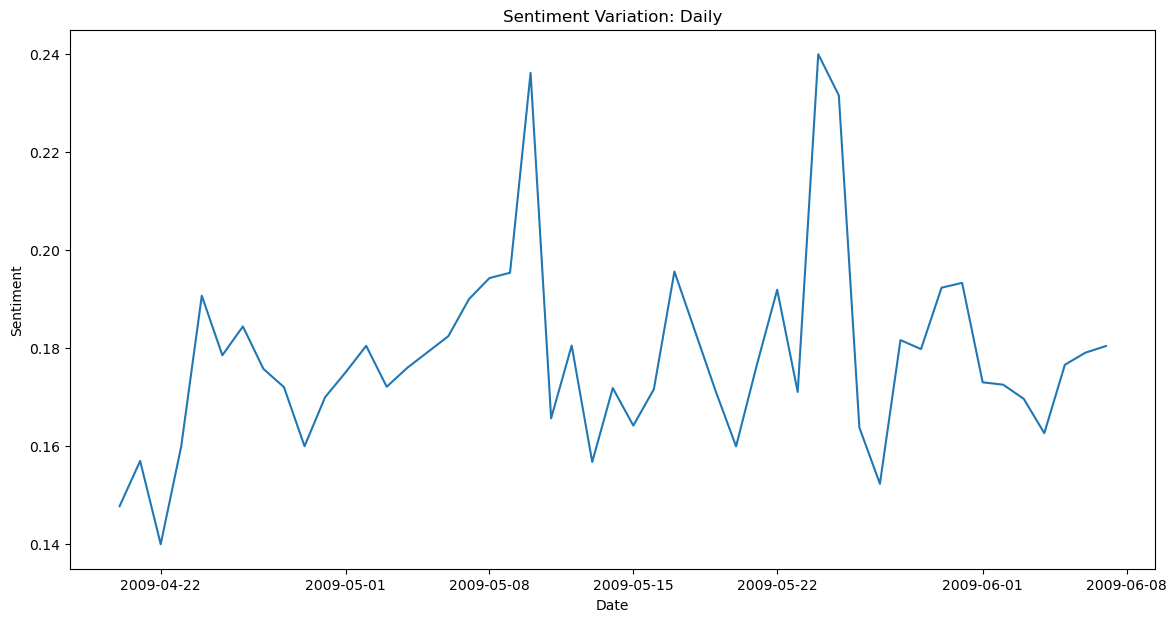

In [41]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (14, 7));

# Ploting graph lines
ax.plot(dfTweetsPrep.index, dfTweetsPrep['sentiment_blob'], label='Blob sentiment');  # Plot first line of data.

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

<b>Plotting the trend and seasonality analysis:</b>

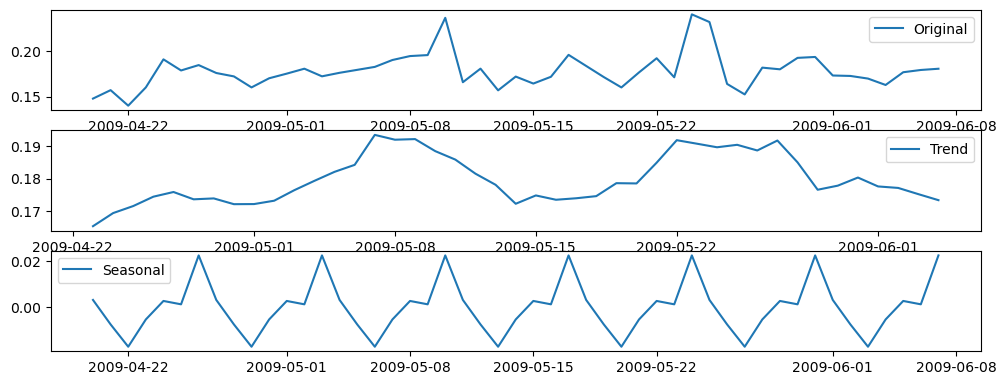

In [42]:
result = seasonal_decompose(dfTweetsPrep['sentiment_blob'], model = 'additive')

trend = result.trend
seasonal = result.seasonal

plt.figure(figsize = (12, 6))
plt.subplot(4, 1, 1)
plt.plot(dfTweetsPrep['sentiment_blob'], label = 'Original')
plt.legend(loc = 'best')
plt.subplot(4, 1, 2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

# Modeling - Machine Learning

## Recursive autoregressive forecasting

In [43]:
#Preparing the dataset to be tested
dfTweetsPredict = dfTweetsPrep
dfTweetsPredict = dfTweetsPredict.rename(columns = {'sentiment_blob': 'y'})
dfTweetsPredict = dfTweetsPredict.asfreq('1D')
dfTweetsPredict = dfTweetsPredict.sort_index()
dfTweetsPredict.head()



,y
date,
2009-04-20,0.147757
2009-04-21,0.157000
2009-04-22,0.140000
2009-04-23,0.160000
2009-04-24,0.190716


In [44]:
print(f'Number of rows with missing values: {dfTweetsPredict.isnull().any(axis = 1).mean()}')

Number of rows with missing values: 0.0


In [45]:
# Verify that a temporary index is complete
# ==============================================================================
(dfTweetsPredict.index == pd.date_range(start = dfTweetsPredict.index.min(),
                             end = dfTweetsPredict.index.max(),
                             freq = dfTweetsPredict.index.freq)).all()

True

In [46]:
# Set the lag and steps parameters
steps = 8
iLags = 21


Train dates : 2009-04-20 00:00:00 --- 2009-05-30 00:00:00  (n = 41)
Test dates  : 2009-05-31 00:00:00 --- 2009-06-07 00:00:00  (n = 8)


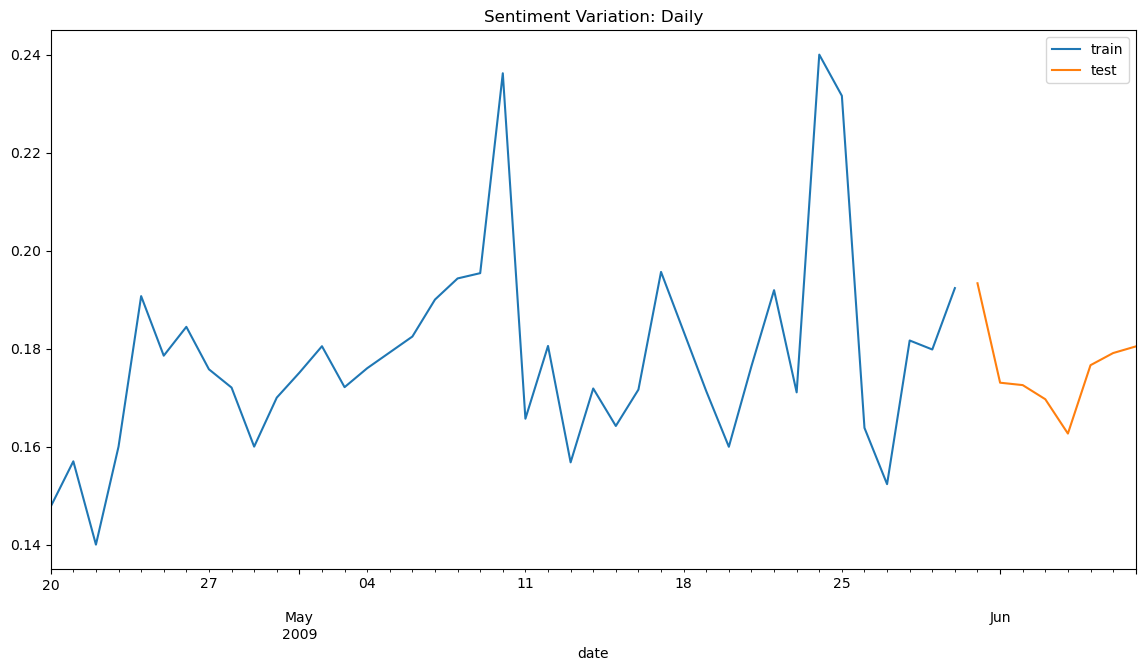

In [47]:
# Split data into train-test
# ==============================================================================

data_train = dfTweetsPredict[:-steps]
data_test  = dfTweetsPredict[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n = {len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n = {len(data_test)})")

fig, ax = plt.subplots(figsize = (14, 7))
data_train['y'].plot(ax = ax, label = 'train')
data_test['y'].plot(ax = ax, label = 'test')
ax.legend();
ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [48]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state = 123),
                lags = iLags
                )

forecaster.fit(y = data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-20 00:00:00'), Timestamp('2009-05-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-30 13:04:21 
Last fit date: 2023-10-30 13:

In [49]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps = steps)
predictions.head(10)

2009-05-31    0.186907
2009-06-01    0.200673
2009-06-02    0.185202
2009-06-03    0.172149
2009-06-04    0.169169
2009-06-05    0.173879
2009-06-06    0.181158
2009-06-07    0.189669
Freq: D, Name: pred, dtype: float64

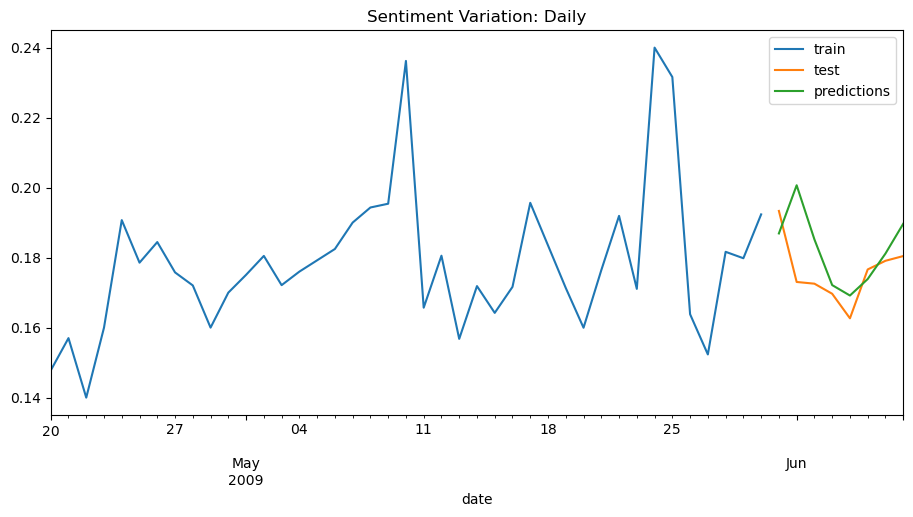

In [50]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize = (11, 5))
data_train['y'].plot(ax = ax, label = 'train')
data_test['y'].plot(ax = ax, label = 'test')
predictions.plot(ax = ax, label = 'predictions')
ax.legend();
ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.

In [51]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0001387516343851414


## Forecast 

In [52]:
# Save model
dump(forecaster, filename='forecaster.py')
# Load model
forecaster_loaded = load('forecaster.py')

# Forecast
psForecast7 = forecaster_loaded.predict(steps = (7 + steps))
psForecast30 = forecaster_loaded.predict(steps = (30 + steps))
psForecast90 = forecaster_loaded.predict(steps = (90 + steps))

### Forecast - 7 days

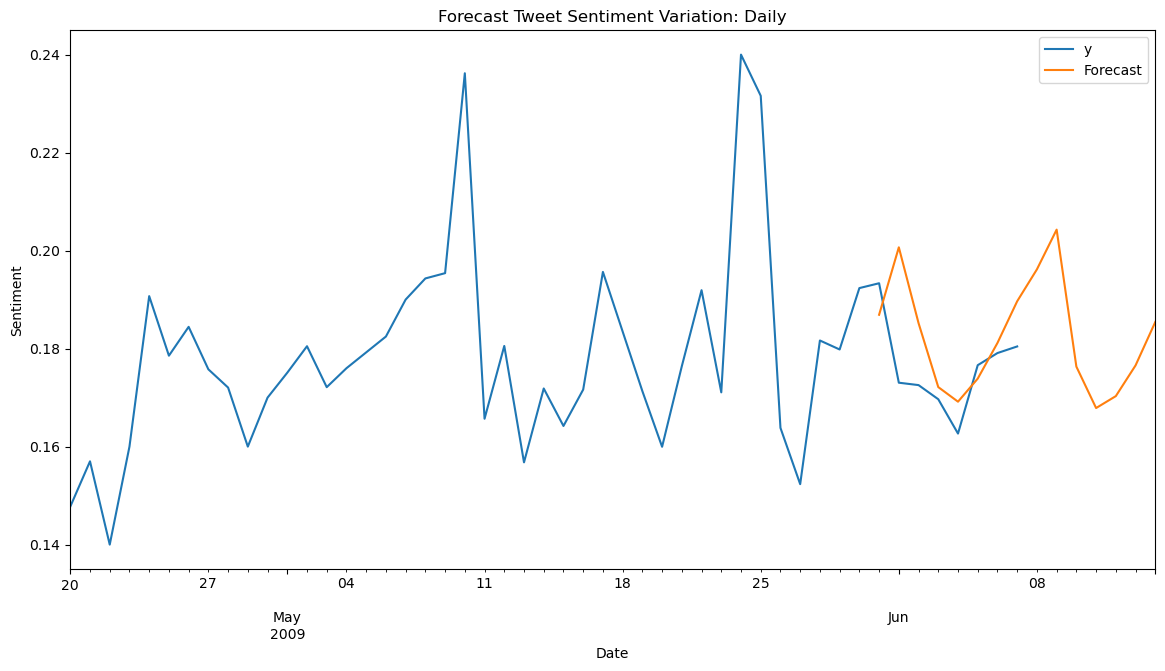

In [53]:
ax = dfTweetsPredict.plot(label = 'Observed', figsize = (14, 7))
psForecast7.plot(ax = ax, label = 'Forecast')
ax.set_title("Forecast Tweet Sentiment Variation: Daily");  # Add a title to the graph.
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.legend()
plt.show()

### Forecast - 30 days

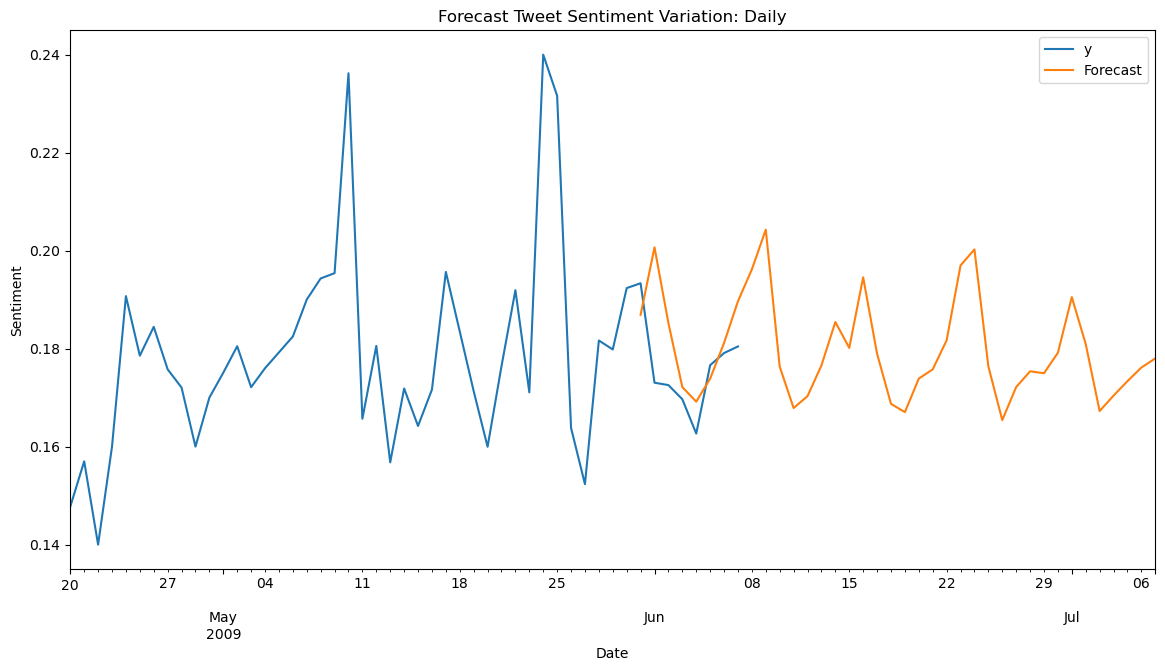

In [54]:
ax = dfTweetsPredict.plot(label = 'Observed', figsize = (14, 7))
psForecast30.plot(ax = ax, label = 'Forecast')
ax.set_title("Forecast Tweet Sentiment Variation: Daily");  # Add a title to the graph.
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.legend()
plt.show()

### Forecast - 90 days

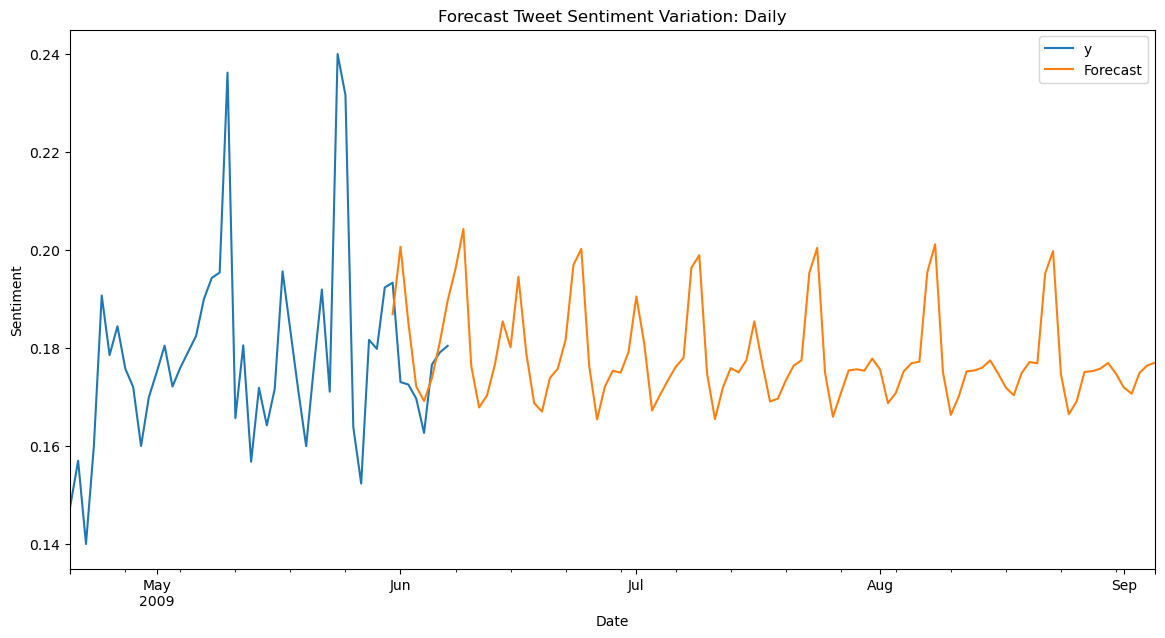

In [55]:
ax = dfTweetsPredict.plot(label = 'Observed', figsize = (14, 7))
psForecast90.plot(ax = ax, label = 'Forecast')
ax.set_title("Forecast Tweet Sentiment Variation: Daily");  # Add a title to the graph.
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.legend()
plt.show()

In [56]:
#%matplotlib widget
#import ipywidgets as widgets

#x = np.linspace(0, 2 * np.pi, 100)
 
#fig, ax = plt.subplots()
#line, = ax.plot(x, np.sin(x))
#ax.grid(True)
 
#def update(change):
#    line.set_ydata(np.sin(change.new * x))
#    fig.canvas.draw()
     
#int_slider = widgets.IntSlider(
#    value=1, 
#    min=0, max=10, step=1,
#    description='$\omega$',
#    continuous_update=False
#)
#int_slider.observe(update, 'value')
#int_slider

## Autoregressive Integrated Moving Average (ARIMA)

In [57]:
dfArima = dfTweetsPredict

y = dfArima['y']

In [58]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


The best AIC for Arima is the lowest number:

In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91221D-01    |proj g|=  3.61145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     17      1     0     0   2.160D-04  -2.912D-01
  F = -0.29123201014843464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-26.540736994546595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.942E+01  -gs= 4.780E-01 BFGS update SKIPPED

At iterate    5    f=  1.13676D+01    |proj g|=  2.43278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     35      2     1     0   5.112D-16   1.137D+01
  F =   11.367625475855599     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1118.0272966338487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60833D+00    |proj g|=  9.08352D-03

           * * *

Tit  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21624D+00    |proj g|=  2.86274D+01

At iterate    5    f= -1.31976D+00    |proj g|=  2.48200D-01

At iterate   10    f= -1.32453D+00    |proj g|=  8.53875D-02

At iterate   15    f= -1.32662D+00    |proj g|=  2.24499D+00

At iterate   20    f= -1.53692D+00    |proj g|=  1.02516D+01

At iterate   25    f= -1.71242D+00    |proj g|=  7.45822D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     64      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.74668D-01    |proj g|=  2.44225D-01

At iterate   10    f= -9.86885D-01    |proj g|=  6.70642D+00

At iterate   15    f= -1.12934D+00    |proj g|=  1.74742D-01

At iterate   20    f= -1.13302D+00    |proj g|=  3.42849D-01

At iterate   25    f= -1.13383D+00    |proj g|=  3.36243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     54      1     0     0   3.362D-03  -1.134D+00
  F =  -1.1338335170705112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-105.11568467291009
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.51875D-01    |proj g|=  4.24991D-01

At iterate   10    f= -5.52031D-01    |proj g|=  4.05608D+00

At iterate   15    f= -5.65421D-01    |proj g|=  3.97988D+01

At iterate   20    f= -6.09684D-01    |proj g|=  4.95964D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     51      1     0     0   2.812D-03  -6.098D-01
  F = -0.60981177261855546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-53.76155371661844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     31      2     0     0   7.233D-04  -1.601D+00
  F =  -1.6014546044027680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-152.94255123147127
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49100D+01    |proj g|=  1.80582D+01
  ys=-1.509E+01  -gs= 4.556E-01 BFGS update SKIPPED
  ys=-1.452E+01  -gs= 4.549E-01 BFGS update SKIPPED

           * * *

Tit   = total 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.38021D+00    |proj g|=  1.01551D-01

At iterate   10    f= -1.38348D+00    |proj g|=  2.77882D+00

At iterate   15    f= -1.39633D+00    |proj g|=  6.72708D-01

At iterate   20    f= -1.41779D+00    |proj g|=  7.16797D+00

At iterate   25    f= -1.52147D+00    |proj g|=  1.97045D+00

At iterate   30    f= -1.72817D+00    |proj g|=  2.06492D+00

At iterate   35    f= -1.73092D+00    |proj g|=  1.14931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     70      1     0     0   7.806D-03  -1.731D+00
  F =  -1.7309171145926781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21371D+00    |proj g|=  6.03820D+00

At iterate    5    f= -1.22899D+00    |proj g|=  4.06556D-02

At iterate   10    f= -1.22916D+00    |proj g|=  7.21368D-01

At iterate   15    f= -1.23031D+00    |proj g|=  2.60896D-02

At iterate   20    f= -1.23040D+00    |proj g|=  4.83249D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     71      2     0     0   4.376D-03  -1.230D+00
  F =  -1.2303986324442493     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-114.57906597953642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22731D-01    |proj g|=  4.03805D+01

At iterate    5    f= -7.73539D-01    |proj g|=  4.32456D-01

At iterate   10    f= -9.75752D-01    |proj g|=  6.54297D+00

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     61      2     0     0   4.125D+04   1.391D+01
  F =   13.914745398133558     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1367.6450490170887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44516D+00    |proj g|=  1.04720D+01

At iterate    5    f= -1.46656D+00    |proj g|=  2.48859D-03
  ys=-4.354E-11  -gs= 2.750E-11 BFGS update SKIPPED

           * * *

Tit  

 This problem is unconstrained.



At iterate    5    f= -9.32791D-01    |proj g|=  1.01447D+00

At iterate   10    f= -1.03401D+00    |proj g|=  7.80392D+00

At iterate   15    f= -1.05634D+00    |proj g|=  1.26578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     25      1     0     0   1.126D-03  -1.056D+00
  F =  -1.0563379782125635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-99.52112186483122
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.33542D+01    |proj g|=  6.79896D-14

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     26      1     0     0   6.799D-14   1.335D+01
  F =   13.354153959438788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1314.7070880250012
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07550D+00    |proj g|=  6.77612D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      5      1     0     0   4.897D-03  -1.076D+00
  F =  -1.0755005494409282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-101.39905384521096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.27290D-01    |proj g|=  3.11966D+00


 This problem is unconstrained.



At iterate    5    f= -9.33392D-01    |proj g|=  1.25809D+00

At iterate   10    f= -1.02982D+00    |proj g|=  3.69963D+00

At iterate   15    f= -1.03472D+00    |proj g|=  2.61329D-02

At iterate   20    f= -1.03604D+00    |proj g|=  6.85385D-01

At iterate   25    f= -1.03678D+00    |proj g|=  3.44128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     34      1     0     0   2.581D-04  -1.037D+00
  F =  -1.0367821706022196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-95.60465271901751
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.754E+01  -gs= 6.763E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     47      3     2     0   5.851D+04   1.403D+01
  F =   14.032340083008862     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1381.1693281348685
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43045D+00    |proj g|=  4.98956D-01

At iterate    5    f= -1.43067D+00    |proj g|=  4.72044D-01

At iterate   10    f= -

/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.44847D+00    |proj g|=  5.36111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     29      1     0     0   3.392D-03  -1.448D+00
  F =  -1.4484660392080126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-137.94967184238524
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.78598D-01    |proj g|=  2.69417D+00

At iterate    5    f= -8.83531D-01    |proj g|=  1.06179D+00

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.80665D+00    |proj g|=  1.01383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     49      1     0     0   3.852D-05  -1.807D+00
  F =  -1.8066480381225161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-171.05150773600658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87485D+01    |proj g|=  3.36612D+01
  ys=-2.754E+01  -gs= 6.772E-01 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-2.754E+01  -gs= 6.763E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     47      3     2     0   5.851D+04   1.326D+01
  F =   13.258885408730452     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1307.3707700555842
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07043D+00    |proj g|=  4.27460D+00


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.08153D+00    |proj g|=  1.53365D-01

At iterate   10    f= -1.08203D+00    |proj g|=  1.01468D-02

At iterate   15    f= -1.08244D+00    |proj g|=  5.92513D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     33      1     0     0   3.295D-03  -1.082D+00
  F =  -1.0824464206368485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-100.07974922241115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   15    f= -9.87128D-01    |proj g|=  1.63851D-02

At iterate   20    f= -9.87296D-01    |proj g|=  2.33396D-01

At iterate   25    f= -9.88988D-01    |proj g|=  6.08278D-02

At iterate   30    f= -9.88996D-01    |proj g|=  4.36203D-02

At iterate   35    f= -9.89026D-01    |proj g|=  6.47206D-02

At iterate   40    f= -9.89266D-01    |proj g|=  6.16920D-02

At iterate   45    f= -9.89285D-01    |proj g|=  8.96996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     58      1     0     0   9.975D-03  -9.893D-01
  F = -0.98928538514323439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-6.076E+00  -gs= 6.863E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     68      3     1     0   6.106D+00  -1.696D+00
  F =  -1.6959738119394843     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-160.20543357006946
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64336D+00    |proj g|=  1.20243D-02
  ys=-1.086E-10  -gs= 1.647E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of functio

/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55555D+01    |proj g|=  1.89495D+01
  ys=-1.560E+01  -gs= 4.753E-01 BFGS update SKIPPED
  ys=-1.390E+01  -gs= 4.735E-01 BFGS update SKIPPED


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     46      3     2     0   1.945D+04   1.206D+01
  F =   12.058991840754803     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1187.7812003939707
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41536D+00    |proj g|=  3.11013D+01

At iterate    5    f= -1.51782D+00    |proj g|=  3.77437D-01

At iterate   10    f= -1.57499D+00    |proj g|=  8.66562D+00

At iterate   

 This problem is unconstrained.



At iterate   10    f= -1.44490D+00    |proj g|=  3.51926D-01

At iterate   15    f= -1.70269D+00    |proj g|=  2.57624D-01

At iterate   20    f= -1.70274D+00    |proj g|=  1.85764D-01

At iterate   25    f= -1.70564D+00    |proj g|=  2.46715D+00

At iterate   30    f= -1.71252D+00    |proj g|=  1.28895D+00

At iterate   35    f= -1.71303D+00    |proj g|=  4.68430D-01

At iterate   40    f= -1.71452D+00    |proj g|=  8.18416D-02

At iterate   45    f= -1.71454D+00    |proj g|=  1.61818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     94      1     0     0   1.618D-02  -1.715D+00
  F =  -1.71454099554


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.06993D-01    |proj g|=  3.77539D+01

At iterate    5    f= -9.21776D-01    |proj g|=  1.56302D+01


 This problem is unconstrained.



At iterate   10    f= -1.17156D+00    |proj g|=  4.58185D-01

At iterate   15    f= -1.17774D+00    |proj g|=  7.18595D-01

At iterate   20    f= -1.17892D+00    |proj g|=  7.97410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   2.465D-02  -1.179D+00
  F =  -1.1789374226089153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-107.53586741567369
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-229.71182928886765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88467D-01    |proj g|=  3.34322D+01
  ys=-9.366E+00  -gs= 7.360E-01 BFGS update SKIPPED


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.68433D+00    |proj g|=  6.64866D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     40      2     1     0   6.649D+00  -1.684D+00
  F =  -1.6843269977318573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-157.06404577772201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60185D+00    |proj g|=  6.08192D-01

At iterate    5    f= -1.60195D+00    |proj g|=  2.02673D-01

At iterate  

 This problem is unconstrained.


  ys=-1.454E+01  -gs= 4.549E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     46      3     2     0   2.030D+04   1.151D+01
  F =   11.507713991876830     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1135.7559712039294
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42352D+00    |proj g|=  3.36886D+01

At iterate    5    f= -1.56224D+00    |proj g|=  3.79471D+00

At iterate   10    f= -1.62232D+00    |proj g|=  4.79793D-02

At iterate   15    f= -1.62366D+00    |proj g|=  2.26215D+00

At iterate   20    f= -1.70998D+00    |proj g|=  6.59282D+00

At iterate   25    f= -1.71846D+00    |proj g|=  4.94052D-01

At iterate   30    f= -1.75422D+00    |proj g|=  5.44592D+00

At iterate   35    f= -1.80199D+00    |proj g|=  6.21208D+00

At iterate   40    f= -1.81022D+00    |proj g|=  4.49415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

 This problem is unconstrained.



At iterate    5    f= -1.35774D+00    |proj g|=  5.52237D+00

At iterate   10    f= -1.48220D+00    |proj g|=  1.13385D+01

At iterate   15    f= -1.64485D+00    |proj g|=  1.84230D+00

At iterate   20    f= -1.64771D+00    |proj g|=  1.25413D+00

At iterate   25    f= -1.70664D+00    |proj g|=  6.27570D+00

At iterate   30    f= -1.74442D+00    |proj g|=  1.02239D-01

At iterate   35    f= -1.74444D+00    |proj g|=  1.48548D-01

At iterate   40    f= -1.74624D+00    |proj g|=  1.76134D+00

At iterate   45    f= -1.75082D+00    |proj g|=  7.49065D-02

At iterate   50    f= -1.75083D+00    |proj g|=  1.47650D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -1.17340D+00    |proj g|=  2.35225D-02

At iterate   10    f= -1.17368D+00    |proj g|=  8.94205D-01

At iterate   15    f= -1.17440D+00    |proj g|=  9.58183D-03

At iterate   20    f= -1.17450D+00    |proj g|=  1.54263D-01

At iterate   25    f= -1.17481D+00    |proj g|=  4.53683D-02

At iterate   30    f= -1.17486D+00    |proj g|=  8.52948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     47      1     0     0   6.983D-03  -1.175D+00
  F =  -1.1748559390459750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-107.135882026

 This problem is unconstrained.



At iterate   15    f= -1.08595D+00    |proj g|=  6.73977D+00

At iterate   20    f= -1.12833D+00    |proj g|=  2.22898D-01

At iterate   25    f= -1.13075D+00    |proj g|=  8.68569D-01

At iterate   30    f= -1.13145D+00    |proj g|=  6.10305D-02

At iterate   35    f= -1.13145D+00    |proj g|=  5.36892D-02

At iterate   40    f= -1.13154D+00    |proj g|=  2.45844D-02

At iterate   45    f= -1.13157D+00    |proj g|=  3.97066D-02


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -1.13159D+00    |proj g|=  3.93056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   3.931D-03  -1.132D+00
  F =  -1.1315900474933673     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-100.89582465435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32385D+00    |proj g|=  2.08163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     71      2     0     0   2.565D-03  -1.473D+00
  F =  -1.4728248984598311     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-140.33684004906345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.25420D-01    |proj g|=  2.75096D+00

At iterate    5    f= -9.30376D-01    |proj g|=  1.16256D+00

At iterate   10    f= -1.04193D+00    |proj g|=  5.81000D+00

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66240D+00    |proj g|=  6.33007D+00

At iterate    5    f= -1.66818D+00    |proj g|=  5.10511D-02

At iterate   10    f= -1.66885D+00    |proj g|=  1.44192D+00

At iterate   15    f= -1.67024D+00    |proj g|=  5.36766D-03

At iterate   20    f= -1.67028D+00    |proj g|=  2.28704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     28      1     0     0   7.688D-04  -1.670D+00
  F =  -1.6702804227620098     

CONVERGENCE: REL_REDUCTION_OF_F_<


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     73      2     1     0   5.404D+05   8.444D+00
  F =   8.4444234271905891     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:835.5534958646778
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01796D+00    |proj g|=  3.25876D+00

At iterate    5    f= -1.02441D+00    |proj g|=  3.10747D-01

At iterate   10    f= -1.02473D+00    |proj g|=  6.33518D-03

           * *

 This problem is unconstrained.



At iterate   15    f= -1.03692D+00    |proj g|=  6.57648D-02

At iterate   20    f= -1.03736D+00    |proj g|=  8.01821D-01

At iterate   25    f= -1.03787D+00    |proj g|=  1.40726D-02

At iterate   30    f= -1.03870D+00    |proj g|=  2.57295D-01

At iterate   35    f= -1.03914D+00    |proj g|=  1.42635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     48      1     0     0   5.670D-03  -1.039D+00
  F =  -1.0391376934992804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-93.83549396292949
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.40157D+00    |proj g|=  2.43310D+00

At iterate   25    f= -2.40251D+00    |proj g|=  3.37700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     36      1     0     0   1.068D-02  -2.403D+00
  F =  -2.4025082663066226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-229.44581009804904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95105D+01    |proj g|=  3.42181D+01
  ys=-1.768E+

/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     29      2     1     0   8.789D+03   1.562D+01
  F =   15.616301569398841     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1538.3975538010864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45586D+00    |proj g|=  1.65373D+00

At iterate    5    f= -1.46520D+00    |proj g|=  4.63242D+00

At iterate   10    f= -1.50745D+00    |proj g|=  1.42117D-01

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -9.21658D-01    |proj g|=  5.56741D+00

At iterate   10    f= -1.03593D+00    |proj g|=  6.59801D-01

At iterate   15    f= -1.05563D+00    |proj g|=  2.04307D+00

At iterate   20    f= -1.05668D+00    |proj g|=  7.19757D-02

At iterate   25    f= -1.05712D+00    |proj g|=  1.54532D-02

At iterate   30    f= -1.05712D+00    |proj g|=  9.81906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     63      1     0     0   9.819D-03  -1.057D+00
  F =  -1.0571235345998864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-95.5981063907


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.76952D+00    |proj g|=  2.33911D-02

At iterate   30    f= -1.76989D+00    |proj g|=  7.95431D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     68      2     0     0   8.903D-03  -1.770D+00
  F =  -1.7698898759403392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-165.44920784215324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87371D+01    |proj g|=  3.42181D+01
  ys=-1.768E+02  -gs= 6.912E-01 BFGS update SKIPPED


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     29      2     1     0   8.789D+03   1.484D+01
  F =   14.842846973704333     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1464.5990034230247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02758D+00    |proj g|=  4.28872D+00

At iterate    5    f= -1.03936D+00    |proj g|=  5.67178D-01

At iterate   10    f= -1.06830D+00    |proj g|=  7.08907D+00

At iterate   

 This problem is unconstrained.



At iterate    5    f= -9.14232D-01    |proj g|=  3.01645D+00

At iterate   10    f= -1.03378D+00    |proj g|=  1.38954D-01

At iterate   15    f= -1.03739D+00    |proj g|=  3.13399D-02

At iterate   20    f= -1.03796D+00    |proj g|=  2.13304D-01

At iterate   25    f= -1.03854D+00    |proj g|=  1.64338D-02

At iterate   30    f= -1.03854D+00    |proj g|=  5.30233D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     99      2     0     0   1.300D-02  -1.039D+00
  F =  -1.0385393951519861     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-91.77686078189187


/home/hduser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<b>Best Arima fit: </b>


In [60]:
if bWithAprilData :
    ### ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-148.4272944748092
    ### ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-152.11004169878163    
    
    mod = sm.tsa.statespace.SARIMAX(y,
                            order = (0, 1, 0),
                            seasonal_order = (0, 0, 0, 12),
                            enforce_stationarity = False,
                            enforce_invertibility = False)
    
else:
    
    mod = sm.tsa.statespace.SARIMAX(y,
                            order = (1, 0, 0),
                            seasonal_order = (0, 0, 0, 12),
                            enforce_stationarity = False,
                            enforce_invertibility = False)

    


    
results = mod.fit(disp = 0)
#print(results.summary().tables[1])


In [61]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   6.22e-05      7.987      0.000       0.000       0.001


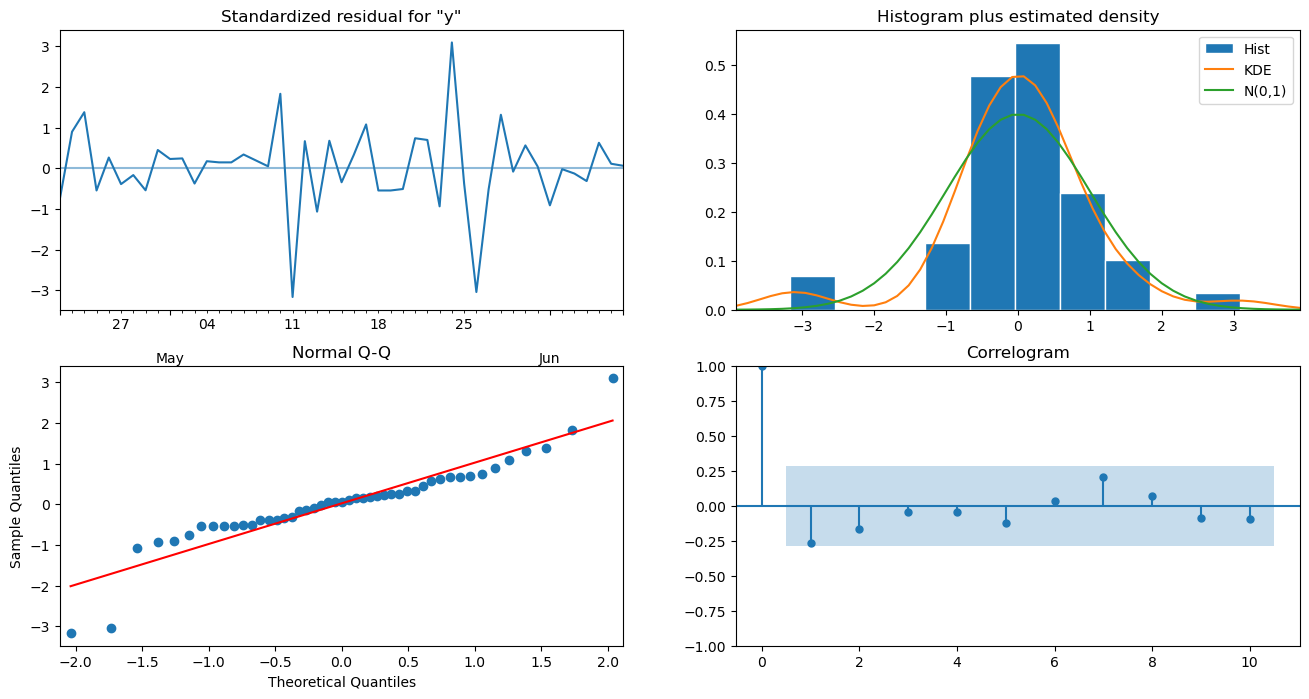

In [62]:
results.plot_diagnostics(figsize = (16, 8))
plt.show()

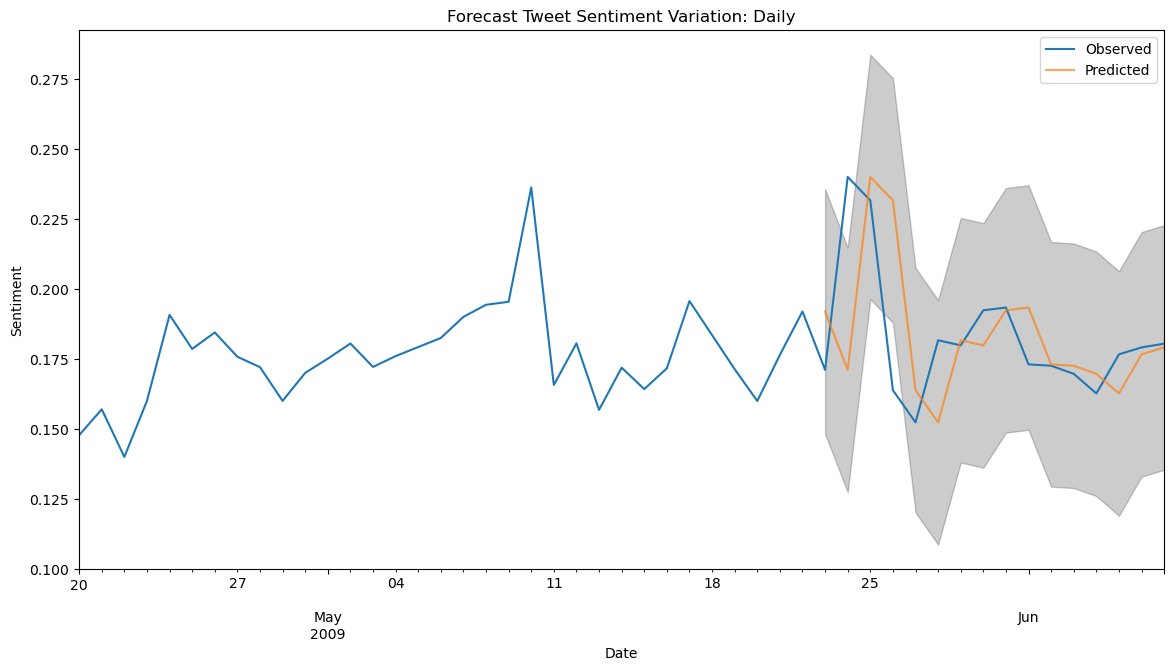

In [63]:
pred = results.get_prediction(start = pd.to_datetime('2009-05-23'), dynamic = False)
pred_ci = pred.conf_int()
ax = y.plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax, label = 'Predicted', alpha = 0.7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.set_title("Forecast Tweet Sentiment Variation: Daily");  # Add a title to the graph.
plt.legend()
plt.show()

In [64]:
y_forecasted = pred.predicted_mean
y_truth = y[:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of this forecasts is ' + str(mse))

#print('The Root Mean Squared Error of forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of this forecasts is 0.000729642832224741


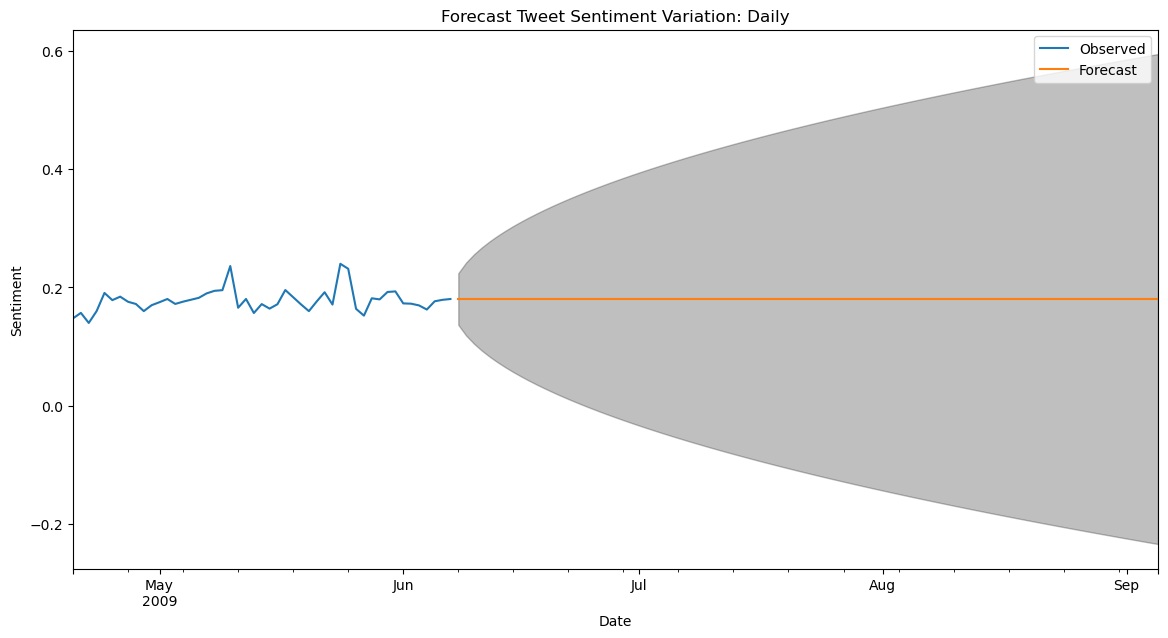

In [65]:
pred_uc = results.get_forecast(steps = 90)
pred_ci = pred_uc.conf_int()
ax = y.plot(label = 'Observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.set_title("Forecast Tweet Sentiment Variation: Daily");  # Add a title to the graph.
plt.legend()
plt.show()

# Performance Analyse: MySQL vs Spark SQL

The same table structure (columns) and same amount of data were used to performe this analyses.
<br/>
<b>Select queries</b> were used to perform the tests. The exactly same queries were executed.
<br/>
<b>Time consuming</b> were the metric used.
<br/>
For each test the Virtual machine were <b>restarted</b> and the jupyter kernel.
<br/>
A first interation (query execution) was performed to "start" the services and avoid test errors.


In [66]:
import mysql.connector
import pymysql
from pyspark.sql import SparkSession
import cProfile
import pandas as pd             

### Spark SQL

In [2]:
# Create a SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

<b>1) Selecting all the values:</b>

In [3]:
#Starting the services
Sparkresults = spark.sql('Select * from dbTwitter.tblTwitter LIMIT 1;')

2023-10-26 07:59:06,007 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-26 07:59:06,008 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-26 07:59:07,800 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-10-26 07:59:07,800 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-10-26 07:59:08,026 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


In [4]:
#Profiling a plot graph code
cProfile.run("Sparkresults = spark.sql('Select * from dbTwitter.tblTwitter;')")

         130 function calls in 0.051 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.051    0.051 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:1467(debug)
        2    0.000    0.000    0.000    0.000 __init__.py:1734(isEnabledFor)
        1    0.000    0.000    0.000    0.000 clientserver.py:230(garbage_collect_object)
        1    0.000    0.000    0.000    0.000 clientserver.py:258(get_thread_connection)
        1    0.000    0.000    0.000    0.000 clientserver.py:271(_get_connection)
        1    0.000    0.000    0.050    0.050 clientserver.py:499(send_command)
        2    0.000    0.000    0.000    0.000 compat.py:113(hasattr2)
        2    0.000    0.000    0.000    0.000 compat.py:92(ispython3bytestr)
        2    0.000    0.000    0.000    0.000 compat.py:95(isbytear

In [5]:
%time Sparkresults = spark.sql('Select * from dbTwitter.tblTwitter;')

CPU times: user 0 ns, sys: 1.34 ms, total: 1.34 ms
Wall time: 42.8 ms


<b>2) Selecting values with string transformations:</b>

In [6]:
sql = """SELECT id, 
              date, 
              user, 
              tweet,              
              SUBSTR(date, 1, 3), 
              SUBSTR(date, 12, 2), 
              SUBSTR(date, 15, 2),                    
              SUBSTR(date, 18, 2),                                      
              SUBSTR(date, 9, 2),                                                        
              CASE SUBSTR(date, 5, 3)                      
                  WHEN 'apr' THEN 4
                  WHEN 'may' THEN 5
                  WHEN 'jun' THEN 6                      
                  ELSE NULL
              END,   
              SUBSTR(date, 25, 4)               
              FROM dbTwitter.tblTwitter"""

cProfile.run("Sparkresults = spark.sql(sql)")

         130 function calls in 0.225 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.225    0.225 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:1467(debug)
        2    0.000    0.000    0.000    0.000 __init__.py:1734(isEnabledFor)
        1    0.000    0.000    0.000    0.000 clientserver.py:230(garbage_collect_object)
        1    0.000    0.000    0.000    0.000 clientserver.py:258(get_thread_connection)
        1    0.000    0.000    0.000    0.000 clientserver.py:271(_get_connection)
        1    0.000    0.000    0.224    0.224 clientserver.py:499(send_command)
        2    0.000    0.000    0.000    0.000 compat.py:113(hasattr2)
        2    0.000    0.000    0.000    0.000 compat.py:92(ispython3bytestr)
        2    0.000    0.000    0.000    0.000 compat.py:95(isbytear

In [7]:
%time Sparkresults = spark.sql(sql)

CPU times: user 712 µs, sys: 160 µs, total: 872 µs
Wall time: 61.9 ms


<b>3) Selecting values groupby clause and numeric transformantions:</b>

In [8]:
sql = """SELECT CAST(seq AS DECIMAL) / 10,
              CAST(seq AS DECIMAL) / 2,
              CAST(seq AS DECIMAL) / 100,
              CAST(seq AS DECIMAL) / 5,
              CAST(seq AS DECIMAL) * 2,
              CAST(seq AS DECIMAL) * 10,
              CAST(seq AS DECIMAL) * 7,
              CAST(seq AS DECIMAL) * 1.3654,
              CAST(seq AS DECIMAL) * 5.7432,
              CAST(seq AS DECIMAL) * 7.2564
            FROM dbTwitter.tblTwitter         """

cProfile.run("Sparkresults = spark.sql(sql)")

         130 function calls in 0.090 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.090    0.090 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:1467(debug)
        2    0.000    0.000    0.000    0.000 __init__.py:1734(isEnabledFor)
        1    0.000    0.000    0.000    0.000 clientserver.py:230(garbage_collect_object)
        1    0.000    0.000    0.000    0.000 clientserver.py:258(get_thread_connection)
        1    0.000    0.000    0.000    0.000 clientserver.py:271(_get_connection)
        1    0.000    0.000    0.089    0.089 clientserver.py:499(send_command)
        2    0.000    0.000    0.000    0.000 compat.py:113(hasattr2)
        2    0.000    0.000    0.000    0.000 compat.py:92(ispython3bytestr)
        2    0.000    0.000    0.000    0.000 compat.py:95(isbytear

In [9]:
%time Sparkresults = spark.sql(sql)

CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 53 ms


### MySQL

In [10]:
# Creating a connection to the mySQL database 
connMySQL = pymysql.connect(host = 'localhost',
                             user = 'user1',
                             password = 'Pass@word1',
                             db = 'dbTwitter')

cursor = connMySQL.cursor()

<b>1) Selecting all the values:</b>

In [13]:
#Starting the service
df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter where id = 0', con = connMySQL)

/tmp/ipykernel_3305/1195738885.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter where id = 0', con = connMySQL)


In [14]:

cProfile.run("df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter', con = connMySQL)")


<string>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


         92945651 function calls (92945640 primitive calls) in 61.656 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    0.000    0.000    0.009    0.001 <__array_function__ internals>:177(copyto)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:150(dirname)
        2    0.000    0.000    0.000    0.000 <frozen posixpath>:41(_get_sep)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:71(join)
        2    0.000    0.000    0

In [15]:
%time df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter', con = connMySQL)

<timed exec>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


CPU times: user 19.3 s, sys: 1.3 s, total: 20.6 s
Wall time: 20.6 s


<b>2) Selecting values with string transformations and numeric calculations:</b>

In [16]:
sql = """SELECT id, 
              date, 
              user, 
              tweet,              
              SUBSTR(date, 1, 3), 
              SUBSTR(date, 12, 2), 
              SUBSTR(date, 15, 2),                    
              SUBSTR(date, 18, 2),                                      
              SUBSTR(date, 9, 2),                                                        
              CASE SUBSTR(date, 5, 3)                      
                  WHEN 'apr' THEN 4
                  WHEN 'may' THEN 5
                  WHEN 'jun' THEN 6                      
                  ELSE NULL
              END,   
              SUBSTR(date, 25, 4)               
              FROM dbTwitter.tblTwitter"""
              
cProfile.run("df = pd.read_sql(sql = sql, con = connMySQL)")

<string>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


         148949738 function calls (148949720 primitive calls) in 93.852 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:177(argsort)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(atleast_2d)
        2    0.000    0.000    0.328    0.164 <__array_function__ internals>:177(concatenate)
       23    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(copyto)
        1    0.000    0.000    0.328    0.328 <__array_function__ internals>:177(vstack)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_i

In [17]:
%time df = pd.read_sql(sql = sql, con = connMySQL)

<timed exec>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


CPU times: user 27 s, sys: 1.68 s, total: 28.7 s
Wall time: 28.7 s


<b>3) Selecting values groupby clause and numeric transformantions:</b>

In [18]:
sql = """SELECT CAST(seq AS DECIMAL)/10,
              CAST(seq AS DECIMAL)/2,
              CAST(seq AS DECIMAL)/100,
              CAST(seq AS DECIMAL)/5,
              CAST(seq AS DECIMAL)*2,
              CAST(seq AS DECIMAL)*10,
              CAST(seq AS DECIMAL)*7,
              CAST(seq AS DECIMAL)*1.3654,
              CAST(seq AS DECIMAL)*5.7432,
              CAST(seq AS DECIMAL)*7.2564
            FROM dbTwitter.tblTwitter"""             

cProfile.run("df = pd.read_sql(sql = sql, con = connMySQL)")

<string>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


         137747540 function calls (137747525 primitive calls) in 104.309 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       22    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(copyto)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:150(dirname)
        2    0.000    0.000    0.000    0.000 <frozen posixpath>:41(_get_sep)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:71(join)
        2    0.000    0.000  

In [19]:
%time df = pd.read_sql(sql = sql, con = connMySQL)

<timed exec>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


CPU times: user 41.7 s, sys: 2.15 s, total: 43.8 s
Wall time: 43.7 s


## MySQL - With column Index

In [34]:
cursor.execute("CREATE INDEX index_id ON tblTwitter (id);")

connMySQL.commit()


cursor.execute("CREATE INDEX index_seq ON tblTwitter (seq);")

connMySQL.commit()

In [36]:
#Starting the service
df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter where id = 0', con = connMySQL)

/tmp/ipykernel_3305/1195738885.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter where id = 0', con = connMySQL)


In [38]:
cProfile.run("df = pd.read_sql(sql = 'SELECT * FROM dbTwitter.tblTwitter', con = connMySQL)")

<string>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


         92945651 function calls (92945640 primitive calls) in 62.391 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(copyto)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:150(dirname)
        2    0.000    0.000    0.000    0.000 <frozen posixpath>:41(_get_sep)
        1    0.000    0.000    0.000    0.000 <frozen posixpath>:71(join)
        2    0.000    0.000    0